In [1]:
import sys
import os
os.chdir("..")

In [2]:
import lasagne
import theano
from theano import tensor as T
import numpy as np

In [3]:
from acgan import *

Using Theano backend.


In [4]:
md = ACGAN(build_generator, {}, build_critic, {'out_nonlinearity':linear},
           latent_dim=100, num_classes=9, in_shp=28, is_grayscale=True, lsgan=True, cls_lambda=0.1)

<lasagne.layers.input.InputLayer object at 0x113c30c50> (None, 100) 
<lasagne.layers.input.InputLayer object at 0x113c30dd0> (None, 9) 
<lasagne.layers.merge.ConcatLayer object at 0x113c30ed0> (None, 109) 
<lasagne.layers.dense.DenseLayer object at 0x10f00ec10> (None, 1024) <function linear at 0x10ecd5398>
<lasagne.layers.normalization.BatchNormLayer object at 0x113c51550> (None, 1024) 
<lasagne.layers.special.NonlinearityLayer object at 0x113c60190> (None, 1024) <function rectify at 0x10ecd5050>
<lasagne.layers.dense.DenseLayer object at 0x113c60310> (None, 6272) <function linear at 0x10ecd5398>
<lasagne.layers.normalization.BatchNormLayer object at 0x113c60550> (None, 6272) 
<lasagne.layers.special.NonlinearityLayer object at 0x113c609d0> (None, 6272) <function rectify at 0x10ecd5050>
<lasagne.layers.shape.ReshapeLayer object at 0x113c60b50> (None, 128, 7, 7) 
<lasagne.layers.conv.TransposedConv2DLayer object at 0x113c60b90> (None, 64, 14, 14) <function linear at 0x10ecd5398>
<lasagn

In [6]:
from load_mnist import load_dataset

In [7]:
_, _, X_valid, y_valid, _, _ = load_dataset()

In [8]:
X_valid.shape, y_valid.shape

((10000, 1, 28, 28), (10000,))

In [9]:
X_valid_zeros = X_valid[ y_valid == 0 ]
X_valid_nonzero = X_valid[ y_valid != 0 ]

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
def gimme_predictions(md, X, X_zeros):
    preds_for_zeros = []
    preds_for_rnd = []
    for b in range( (X_zeros.shape[0] // 32 ) + 1):
        preds_for_zeros += md.disc_fn_det(
            X_zeros[b*32:(b+1)*32]).flatten().tolist()
        preds_for_rnd += md.disc_fn_det(
            np.random.normal(0,0.1,size=(32, 1, 28, 28)).astype("float32") ).flatten().tolist()
    preds_for_nonzero = []
    for b in range( (X.shape[0] // 32 ) + 1):
        preds_for_nonzero += md.disc_fn_det(X[b*32:(b+1)*32]).flatten().tolist()
    return preds_for_zeros, preds_for_rnd, preds_for_nonzero

In [48]:
md.load_model("60.model")

mean response for rnd:  -1.23423950822 +/- 0.762701657066
mean response for zeros: 0.307046144998 +/- 0.282599765781
mean response for in-dist: 0.324474464883 +/- 0.300061618934


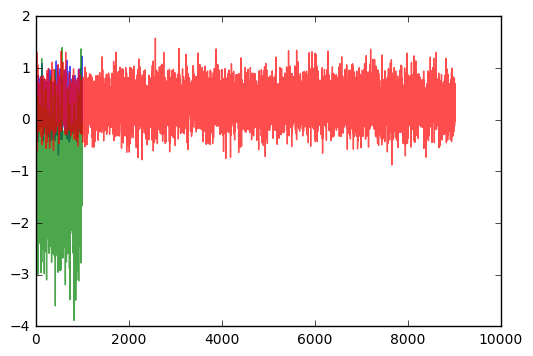

In [49]:
preds_for_zeros, preds_for_rnd, preds_for_nonzero = gimme_predictions(md)
plt.plot(preds_for_zeros, "b-", preds_for_rnd, "g-", preds_for_nonzero, "r-", alpha=0.7)
print "mean response for rnd: ", np.mean(preds_for_rnd), "+/-", np.std(preds_for_rnd) 
print "mean response for zeros:", np.mean(preds_for_zeros), "+/-", np.std(preds_for_zeros) 
print "mean response for in-dist:", np.mean(preds_for_nonzero), "+/-", np.std(preds_for_nonzero) 

* good at separating out noise
* bad at separating ood and id

Potential problem??: train the GAN for too long and the discriminator will become worse at discriminating 1..9, because the generator is so good at generating 1..9s as well that it doesn't know whether the 1..9s are real or fake.

The delta between zeros/id is not good... the variance is also equivalent between the two. If the generator is prevented from becoming too powerful w.r. to fooling the discriminator, then maybe we can make that delta bigger.

----

In [33]:
md.load_model("10.model")

In [45]:
preds_for_zeros, preds_for_rnd, preds_for_nonzero = gimme_predictions(md)

mean response for rnd (green):  0.283311798523 +/- 0.157839625591
mean response for zeros (blue): 0.443941284261 +/- 0.226845794973
mean response for in-dist (red): 0.524619833667 +/- 0.20224300018


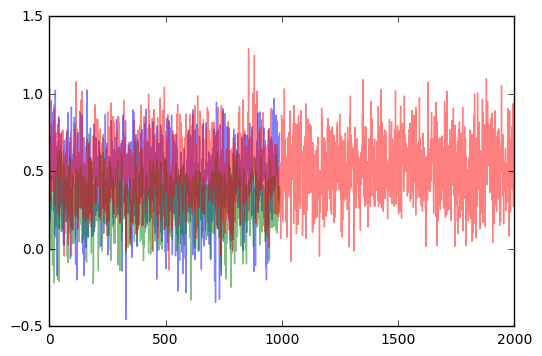

In [46]:
plt.plot(preds_for_zeros[0:2000], "b-", preds_for_rnd[0:2000], "g-", preds_for_nonzero[0:2000], "r-", alpha=0.5)
print "mean response for rnd (green): ", np.mean(preds_for_rnd), "+/-", np.std(preds_for_rnd) 
print "mean response for zeros (blue):", np.mean(preds_for_zeros), "+/-", np.std(preds_for_zeros) 
print "mean response for in-dist (red):", np.mean(preds_for_nonzero), "+/-", np.std(preds_for_nonzero)

* ok at separating out noise
* ok at separating out ood/id

In [120]:
md.load_model("30.model")

In [121]:
preds_for_zeros, preds_for_rnd, preds_for_nonzero = gimme_predictions(md, X_valid_nonzero, X_valid_zeros)

mean response for rnd (green):  -0.13481969867 +/- 0.256340894412
mean response for zeros (blue): 0.338263364259 +/- 0.207679468807
mean response for in-dist (red): 0.488419311852 +/- 0.237825247669


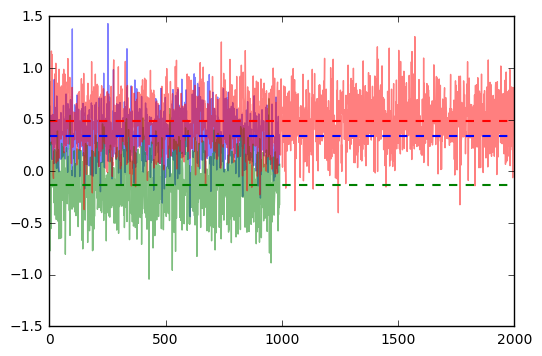

In [122]:
plt.plot(preds_for_zeros[0:2000], "b-", preds_for_rnd[0:2000], "g-", preds_for_nonzero[0:2000], "r-", alpha=0.5)
print "mean response for rnd (green): ", np.mean(preds_for_rnd), "+/-", np.std(preds_for_rnd) 
print "mean response for zeros (blue):", np.mean(preds_for_zeros), "+/-", np.std(preds_for_zeros) 
print "mean response for in-dist (red):", np.mean(preds_for_nonzero), "+/-", np.std(preds_for_nonzero)
plt.axhline(np.mean(preds_for_rnd), color='g', linestyle='dashed', linewidth=1.5)
plt.axhline(np.mean(preds_for_zeros), color='b', linestyle='dashed', linewidth=1.5)
plt.axhline(np.mean(preds_for_nonzero), color='r', linestyle='dashed', linewidth=1.5)

* good at separating out noise
* ok at separating ood/id

How well is the detection with extreme data augmentation?

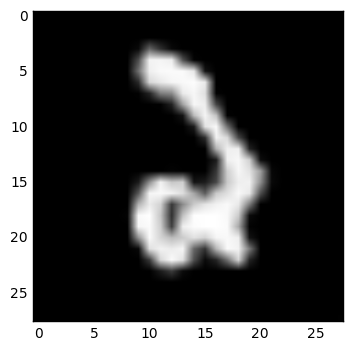

In [114]:
plt.imshow( md.gen_fn_det(md.sample_noise(32), md.sample_yfake(32))[0][0], cmap="gray" )

In [116]:
fakes = []
for b in range( X_valid_zeros.shape[0] // 32 ):
    fake = md.gen_fn_det(md.sample_noise(32), md.sample_yfake(32))
    fakes += md.disc_fn_det(fake).flatten().tolist()

0.416382762262


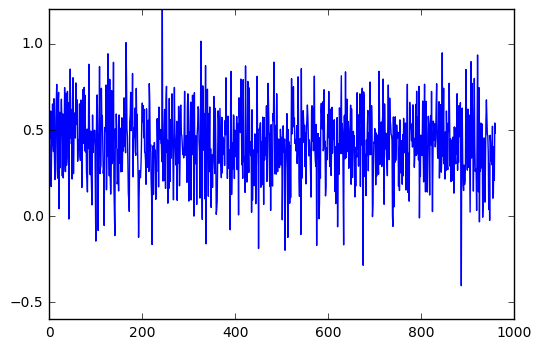

In [118]:
plt.plot(fakes)
print np.mean(fakes)

---------